# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5572 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_table('./SMSSpamCollection.txt', 
                   sep='\t', 
                   names=['Clasificacion','Mensaje'])# Visualización de las 5 primeras filas
df

,Clasificacion,Mensaje
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [5]:
df.describe()

,Clasificacion,Mensaje
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
# Explorar el porcentaje de mensajes SPAM en el dataset
round(100 * df.Clasificacion.value_counts() / sum(df.Clasificacion.value_counts()), 1)

ham     86.6
spam    13.4
Name: Clasificacion, dtype: float64

In [8]:
# Conversion del campo "Clasificacion" a binario para poder usarlo con scikit learn
df['Clasificacion'] = df.Clasificacion.map({'ham':0, 'spam':1})
df

,Clasificacion,Mensaje
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [9]:
#Stemmer
stemmer = PorterStemmer()
df['stemmed'] = df.Mensaje.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))

In [10]:
df

,Clasificacion,Mensaje,stemmed
0,0,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,0,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,0,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,thi is the 2nd time we have tri 2 contact u. U...
5568,0,Will ü b going to esplanade fr home?,will ü b go to esplanad fr home?
5569,0,"Pity, * was in mood for that. So...any other s...","pity, * wa in mood for that. so...ani other su..."
5570,0,The guy did some bitching but I acted like i'd...,the guy did some bitch but I act like i'd be i...


## Regresión Logística

In [11]:
#Transformar los mensajes para poder tilizarlos en la regresión
count_vector = CountVectorizer()
texto = count_vector.fit_transform(df.stemmed).toarray()
print(texto)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
#Separar los set de entrenamento de los de evaluación
XL_train, XL_test, yL_train, yL_test = train_test_split(texto, df['Clasificacion'], random_state=4)
print ('Train set:', XL_train.shape,  yL_train.shape)
print ('Test set:', XL_test.shape,  yL_test.shape)

Train set: (4179, 8260) (4179,)
Test set: (1393, 8260) (1393,)


In [13]:
# Definir el modelo de regresión
LR = LogisticRegression(C=0.01, solver='liblinear').fit(XL_train,yL_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
#realizar la predicción del modelo con el set de evaluación
yhat = LR.predict(XL_test)
yhat

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [15]:
#Para evaluar la precision del modelo, probemos el índice de jaccard, que puede definirse como
#la division entre la intersección y la unión de los conjuntos SPAM y HAM
#Si todas lsa predicciones hechas corresponden a sus valores reales, entonces la precisión es 1.0
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(yL_test, yhat)

C:\Users\BocanegraMartinez\Anaconda3\envs\Vision\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.9361091170136396

In [16]:
#Función para dibujar la matriz de confusión.. por  Saeed Aghabozorgi
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusión',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusión Normalizada")
    else:
        print('Matriz de confusión no Normalizada')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Valores Predichos')
    plt.xlabel('Valores Reales')


Matriz de confusión no Normalizada
[[ 120   89]
 [   0 1184]]


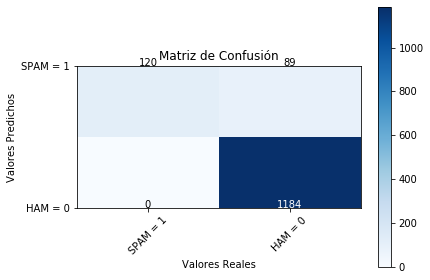

In [17]:
# Calcular la matriz de confusión
cnf_matrix = confusion_matrix(yL_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Graficar Matriz de confusión no Normalizada
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['SPAM = 1','HAM = 0'],normalize= False,  title='Matriz de Confusión')

En la primera fila de la matriz de confusión vemos que los **209 mensajes que eran SPAM** en el set de datos de test, **120 fueron predichos de manera correcta**, y 89 fueron predichos como No SPAM.

EN la segunda fila vemos que **los 1184 mensajes que NO eran SPAM** en el set de datos de evaluación, **todos fueron predichos de manera correcta!**.

In [19]:
# En la regresión Logística, La salisa puede ser la probabilidad de que el mensaje recibido sea SPAM (or equals to 1).
# La probabilidad está entre = y 1. 
from sklearn.metrics import log_loss
yhat_prob = LR.predict_proba(XL_test)

log_loss(yL_test, yhat_prob)

0.21544348797768648

In [20]:
# Miremos la precision, recall, f1-score
print (classification_report(yL_test, yhat))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1184
           1       1.00      0.57      0.73       209

    accuracy                           0.94      1393
   macro avg       0.97      0.79      0.85      1393
weighted avg       0.94      0.94      0.93      1393



## Clasificador Naive Bayes Multinomial

In [21]:
# Dividir los datos en conjunto de entrenamiento y de test

X_train, X_test, y_train, y_test = train_test_split(df['Mensaje'], df['Clasificacion'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 5572
Number of rows in the training set: 4179
Number of rows in the test set: 1393


In [22]:
# Instancir el método CountVectorizer 
count_vector = CountVectorizer()
# Transformar el set de entrenamiento y haciendo fit
training_data = count_vector.fit_transform(X_train)
# Transformar el set de evaluación (sin hacer fit)
testing_data = count_vector.transform(X_test)

Este clasificador particular, la implementación Naive Bayes “multinomial”, es adecuada para la clasificación de características discretas (como un contador de palabras para la clasificación de texto), y toma como entrada el contador completo de palabras.

In [24]:
from sklearn.naive_bayes import MultinomialNB
#se define el modelo y se entrena
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
#Se realizan las predicciónes
predictions = naive_bayes.predict(testing_data)

In [26]:
#Evaluamos el modelo con métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

Accuracy score:  0.9885139985642498
Precision score:  0.9720670391061452
Recall score:  0.9405405405405406
F1 score:  0.9560439560439562


Matriz de confusión no Normalizada
[[ 174   11]
 [   5 1203]]


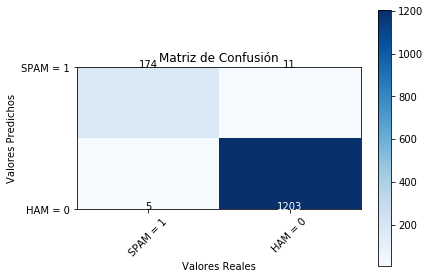

In [27]:
# Calcular la matriz de confusión
bcnf_matrix = confusion_matrix(y_test, predictions, labels=[1,0])
np.set_printoptions(precision=2)

# Graficar Matriz de confusión no Normalizada
plt.figure()
plot_confusion_matrix(bcnf_matrix, classes=['SPAM = 1','HAM = 0'],normalize= False,  title='Matriz de Confusión')

Vemos en la matriz como se logran mejores aciertos en los mensaes que no son SPAM que los que son SPAM. Es decir, un 5% de los mensajes que eran SPAM pasaron inadvertidos para el modelo. Y lo mensajes que no eran SPAM solo tuvieron un 0.4% de error de predicción.

### Red Neuronal 

In [28]:
# Utilización de GridSearchCV para optimizar los parámetros de la red neuronal
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)

In [29]:
parameter_space = {
    'hidden_layer_sizes': [(2,), (5,), (10,)], # tres configuraciones distintas de capas ocultas
    'activation': ['logistic'], # se prueba entre las funciones de activación logística y Relu
    'solver': ['adam'], # se utiliza el solver más apropiado para datos de miles de datos.
    'alpha': [0.0],
    'learning_rate': ['constant'], # se deja la tasa de aprendizaje constante ya que el solver usado no soporta otra
}

In [30]:
from sklearn.model_selection import GridSearchCV
#Se habilita la optimización de parámetros con todos los procesadores y 3 splits para la "cross-valitadion"
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(XL_train, yL_train)

C:\Users\BocanegraMartinez\Anaconda3\envs\Vision\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=100,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['logistic'], 'alpha': [0.0],

In [31]:
# Mejores parámetros encontrados
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'logistic', 'alpha': 0.0, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'adam'}


In [32]:
y_true = np.asanyarray(yL_test)
y_pred =  clf.predict(XL_test)

print("Residual sum of squares: %.2f"
      % np.mean((y_pred - y_true) ** 2))
print('Score: %.2f' % clf.score(XL_test, yL_test))

Residual sum of squares: 0.02
Score: 0.98


>Vemos como la red neuronal también obtiene un resultado muy bueno al igual que los demás modelos ejecuados en este trabajo.
Es claro que con una optimización más exahustiva, los resultados podrían incrementar, pero con un costo computacional asociado.